# Notebook description

The purpose of this notebook is to determine whether or not the time dependence of the data is important for predicting the outcome of ebay sales. We try to answer this question simply by giving the training data time-dependent weights that decrease for older times at a rate determined by a model parameter $\sigma$. Roughly speaking, $\sigma$ parametrizes how far into the past the model sees when training. After training, we score the model (ROC AUC) on test data that is temporally after all the points in the training data. We then tune $\sigma$ to maximize the test score.

# Imports

In [14]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from dateutil.parser import parse
from datetime import timedelta
import pprint as pp

In [15]:
# Read in the pandas.DataFrame from csv
data = pd.read_csv('../Data/ebay_data_rf_endtime.csv', index_col=False)

# Preprocessing

In [16]:
# Separate target variable from inputs
y = data.sellingState
T = data.endTime
X = data.drop(['sellingState','endTime'], axis=1)
T_dt = [parse(x) for x in T]

We can easily see the 90 day limitation of the ebay API:

In [17]:
DeltaT = (T_dt[0]-T_dt[-1])
print("Total days of data:", DeltaT.total_seconds()/86400)

Total days of data: 89.98267361111111


# Testing time dependence

## Determine sample weights based on time

In [18]:
# Calculate the sample weights
def get_days_diff(dt1 , dt2): 
    return (dt1 - dt2).total_seconds()/(86400) 
    # 86400 s/day = 60 s/min * 60 min/hr *24 hr/day

def get_weight(dt, dt_ref, sigma):

    hrs = get_days_diff(dt,dt_ref)
    
    return math.exp( -hrs**2 / (2 * sigma) )

def get_sample_weights(dt_ls, sigma):
    latest = max(dt_ls)
    return [get_weight(x, latest, sigma) for x in dt_ls]

sw = get_sample_weights(T_dt, 2)

In [19]:
# Split the data into train and test. 
#Since we are going to optimize sigma, we split into old and new
frac = 0.1
ind = math.ceil(42028 * frac)

test_ind = range(0,ind)
train_ind = range(ind,len(y))

X_train = X.iloc[train_ind]
X_test = X.iloc[test_ind]
y_train = y[list(train_ind)]
y_test = y[list(test_ind)]

T_dt_train = T_dt[ind:len(y)]

In [20]:
min_sigma = (T_dt[0]-T_dt[ind]).total_seconds()/86400
max_sigma = 2*(T_dt_train[0]-T_dt_train[-1]).total_seconds()/86400
print(min_sigma, max_sigma)

5.420335648148148 169.1246759259259


In [21]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))
print(len(T_dt_train))

(40637, 20)
(4203, 20)
40637
4203
40637


## The classifier model

In [22]:
# Assign the classifier
n_estimators = 200
max_features = 10
weights = {0: 1, 1: 1}
RANDOM_STATE = 3
clf = RandomForestClassifier(n_estimators = n_estimators,
                             max_features=max_features,
                             class_weight=weights,
                             oob_score=False,
                             n_jobs = 3,
                             random_state = RANDOM_STATE
                            )

## Scan over $\sigma$ values

In [23]:
# Calculate the Auc_error for a range of time windows
aucs = []

# Range of sigma to explore (in days)
n_pts = 30
pts = np.linspace(min_sigma, max_sigma, n_pts)

for sig in pts:
    sw = get_sample_weights(T_dt_train, sig)
    clf.fit(X_train, y_train, sw)
    y_pred = clf.predict_proba(X_test)[:,1]
    aucs.append( (sig, roc_auc_score(y_test, y_pred)) )
    
aucs

[(5.4203356481481482, 0.81541152263374483),
 (11.065312899106001, 0.81960373607065229),
 (16.710290150063855, 0.82324848568918485),
 (22.355267401021706, 0.82406089610209454),
 (28.000244651979564, 0.81975227724603505),
 (33.645221902937415, 0.82390368520830437),
 (39.290199153895266, 0.82276714292319775),
 (44.935176404853124, 0.82274252092292044),
 (50.580153655810975, 0.82325137559532069),
 (56.225130906768825, 0.82407257132288336),
 (61.870108157726683, 0.82440548850973316),
 (67.515085408684541, 0.82455795995746062),
 (73.160062659642392, 0.82604579923244081),
 (78.805039910600243, 0.82551243815600872),
 (84.450017161558108, 0.82552677209044245),
 (90.094994412515959, 0.82560202524621995),
 (95.73997166347381, 0.82570548388588338),
 (101.38494891443166, 0.82482683682433999),
 (107.02992616538951, 0.82477158181902255),
 (112.67490341634738, 0.82674700605724327),
 (118.31988066730523, 0.82615781199426641),
 (123.96485791826308, 0.82548561982706803),
 (129.60983516922093, 0.826557890

## Plot the results

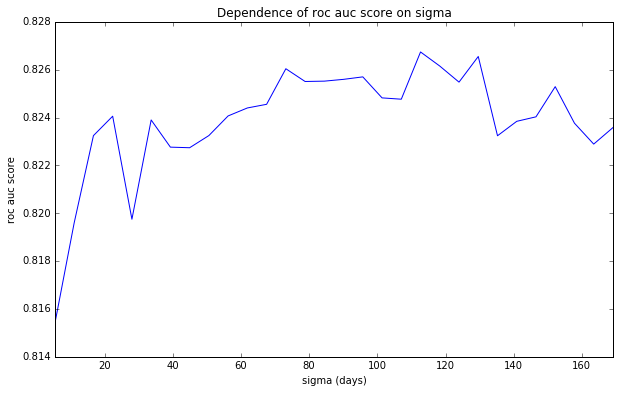

In [24]:
xs, ys = zip(*aucs)

plt.plot(xs, ys)

plt.title("Dependence of roc auc score on sigma")
plt.xlim(min_sigma, max_sigma)
plt.xlabel("sigma (days)")
plt.ylabel("roc auc score")

plt.show()

In [25]:
# Find the maximum value
max(aucs, key = lambda x: x[1])

(112.67490341634738, 0.82674700605724327)

It doesn't appear that over the timescale of the available data (~90 days) that there is any benefit to adjusting the sample weights for older data. While older data doesn't appear to be neccessary to constrain the fit, it doesn't harm the fitting either. Perhaps as the data set grows, the time dependence will become an issue. At present, we will sample all data points equally.